# 図の描画

In [1]:
using PyPlot
using PyCall

fs = 10
plt.style.use("tableau-colorblind10")
plt.rcParams["font.size"] = fs
plt.rcParams["axes.titlesize"] = 10
PyPlot.svg(true)
jm = pyimport("japanize_matplotlib");

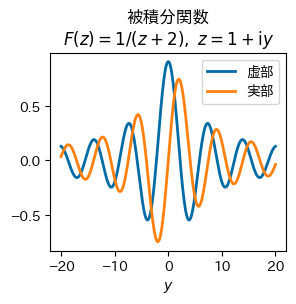

In [2]:
# Bromwich積分(経路は{1 + iy: y ∈ (-oo,oo)})の被積分関数の図
z(y) = 1 + im*y
F(z) = 1/(z+2)
integrand(z,t) = exp(z*t) * F(z)

t = 1
y = LinRange(-20, 20, 301)
g = @. integrand(z(y),t)

fig, ax = subplots(1, 1, figsize=[8,8]/2.54)
ax.plot(y, real.(g), label="虚部", lw=2)
ax.plot(y, imag.(g), label="実部", lw=2)
ax.set_title("被積分関数\n\$F(z)=1/(z+2),~ z=1+\\mathrm{i}y\$")
ax.set_xlabel("\$y\$")
ax.legend()
fig.tight_layout()
fig.savefig("fig1.pdf")
show()

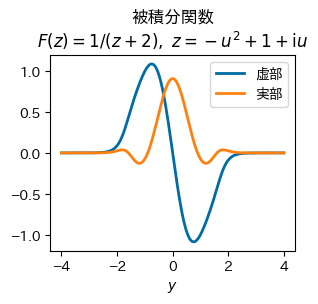

In [3]:
# 積分経路を{-u^2 + 1 + iu: u ∈ (-oo,oo)}とするときの被積分関数
z(u) = -u^2 + 1 + im*u
dz(u) = -2u + im
F(z) = 1/(z+2)
integrand(z,t) = exp(z*t) * F(z)

t = 1
u = LinRange(-4, 4, 301)
g = @. dz(u) * integrand(z(u),t)


fig, ax = subplots(1, 1, figsize=[8,8]/2.54)
ax.plot(u, real.(g), label="虚部", lw=2)
ax.plot(u, imag.(g), label="実部", lw=2)
ax.set_title("被積分関数\n\$F(z)=1/(z+2),~ z=-u^2+1+\\mathrm{i}u\$")
ax.set_xlabel("\$y\$")
ax.legend()
fig.tight_layout()
fig.savefig("fig2.pdf")
show()

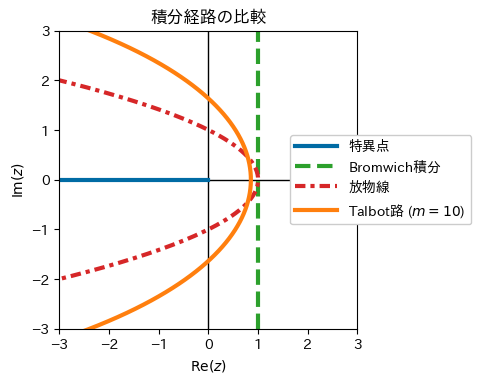

In [4]:
# 積分経路の比較

fig, ax = subplots(1,1, figsize=[15,10]/2.54)

ax.plot([-3,3], [0,0], c="k", lw=1)
ax.plot([0,0], [-3,3], c="k", lw=1)


ax.plot([-3,0], [0,0], lw=3, label="特異点") # 特異点があるところ
ax.plot([1,1], [-3,3], lw=3, c="tab:green", label="Bromwich積分", ls="--") # Bromwich積分

u = LinRange(-3, 3, 200)
Re = @. -u^2 + 1
ax.plot(Re, u, lw=3, c="tab:red", label="放物線", ls=(0,(2.5,1.2,1,1.2))) # 放物線

u = LinRange(-π, π, 300)
Re = @. -0.6122 + 0.5017 * u * cot(0.6407*u)
Im = @. 0.2645 * u
ax.plot(5*Re, 5*Im, lw=3, c="tab:orange", label="Talbot路 (\$m=10\$)") # Talbot(10)

ax.set_title("積分経路の比較")
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_xlabel("\$\\mathrm{Re}(z)\$")
ax.set_ylabel("\$\\mathrm{Im}(z)\$")
ax.set_aspect(1)
ax.legend(bbox_to_anchor=[0.75,0.5], loc="center left", framealpha=1, handlelength=3)

fig.tight_layout()
fig.savefig("fig3.pdf")
show()

# 数値積分に基づく逆ラプラス変換の実装と比較

In [5]:
using PyPlot
using PyCall

fs = 10
plt.style.use("tableau-colorblind10")
plt.rcParams["font.size"] = fs
plt.rcParams["axes.titlesize"] = 10
PyPlot.svg(true)
jm = pyimport("japanize_matplotlib");

In [6]:
function invlaplace_parabola(F, t, m)
    ϵ = 2.0^(-53)
    r = sqrt(-log(ϵ)/t)
    l = -r
    h = (r-l)/(m-1)
    w = fill(h, m)
    w[1], w[m] = h/2, h/2
    
    u = LinRange(l, r, m)
    z = @. -u^2 + 1 + im*u
    dz = @. -2u + im
    g = @. w * dz * exp(z*t) * F(z)
    return sum(g) / (2*π*im)
end


function invlaplace_talbot(F, t, m)
    h = 2π/m
    u = [-π + (k-0.5)*h for k=1:m]
    α = 0.6407
    σ = 0.6122
    μ = 0.5017
    ν = 0.2645
    m_tilde = max(24, m)
    z = @. m_tilde/t * (-σ + μ*u*cot(α*u) + im*ν*u)
    dz = @. m_tilde/t * (μ*cot(α*u) - μ*α*u*csc(α*u)^2 + im*ν)
    approx = sum(@. dz * exp(t*z) * F(z)) / (im*m)
    return approx
end;

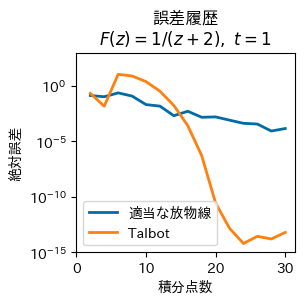

In [7]:
# 問題1の誤差履歴をとってプロット
m_list = 2:2:30

F(z) = 1 / (z+2)
f(t) = exp(-2t)
t = 1.0
exact = f(t)
err_p = zeros(length(m_list))
err_t = zeros(length(m_list))

for (i,m) in enumerate(m_list)
    f_p = invlaplace_parabola(F, t, m)
    err_p[i] = abs(f_p - exact)
    
    f_t = invlaplace_talbot(F, t, m)
    err_t[i] = abs(f_t - exact)
end

fig, ax = subplots(1, 1, figsize=[8,8]/2.54)
ax.plot(m_list, err_p, label="適当な放物線", lw=2)
ax.plot(m_list, err_t, label="Talbot", lw=2)
ax.set_yscale("log")
ax.set_xlabel("積分点数")
ax.set_ylabel("絶対誤差")
ax.set_title("誤差履歴\n\$F(z) = 1/(z+2), ~ t=1\$")
ax.set_xticks([0,10,20,30])
ax.set_yticks([1e-15,1e-10,1e-5,1e0])
ax.set_ylim(1e-15, 1e3)
ax.legend(loc="lower left")
fig.tight_layout()
fig.savefig("fig4.pdf")
show()

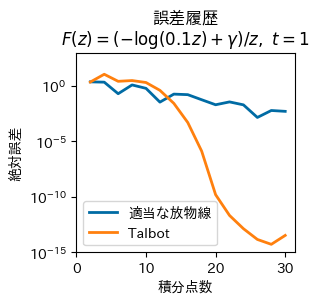

In [8]:
# 問題2の誤差履歴をとってプロット
m_list = 2:2:30

F(z) = -(log(z/10) + Base.MathConstants.γ)/z
f(t) = log(10t)
t = 1.0
exact = f(t)
err_p = zeros(length(m_list))
err_t = zeros(length(m_list))

for (i,m) in enumerate(m_list)
    f_p = invlaplace_parabola(F, t, m)
    err_p[i] = abs(f_p - exact)
    
    f_t = invlaplace_talbot(F, t, m)
    err_t[i] = abs(f_t - exact)
end

fig, ax = subplots(1, 1, figsize=[8,8]/2.54)
ax.plot(m_list, err_p, label="適当な放物線", lw=2)
ax.plot(m_list, err_t, label="Talbot", lw=2)
ax.set_yscale("log")
ax.set_xlabel("積分点数")
ax.set_ylabel("絶対誤差")
ax.set_title("誤差履歴\n\$F(z) = (-\\log(0.1z) + \\gamma)/z, ~ t=1\$")
ax.set_xticks([0,10,20,30])
ax.set_yticks([1e-15,1e-10,1e-5,1e0])
ax.set_ylim(1e-15, 1e3)
ax.legend(loc="lower left")
fig.tight_layout()
fig.savefig("fig5.pdf")
show()